In [170]:
from typing import Dict, List, Tuple, Union
from gym import Space, spaces
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from env import PrisonersDilemmaEnv
import utils
from importlib import reload
reload(utils)

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (7, 4)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.facecolor'] = 'white'

### Run experiments [standard]

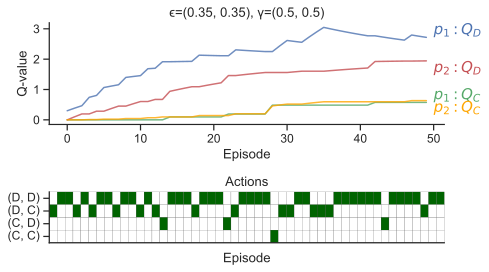

In [171]:
# Setup config
config = {
    'num_simuls': 1,
    'num_episodes': 50,
    'num_agents': 2,
    'num_actions': 2,
    'verbose': False,
    'init_type':'zeros',
}

config['payoffs'] = {
    'R': 2,
    'T': 3,
    'S': 0,
    'P': 1,
}

config['params'] = {
    'alpha': np.array([0.1, 0.1]),
    'eps': np.array([0.35, 0.35]),
    'gamma': np.array([0.5, 0.5]),
}

# Run experiments
q_traj_one, q_traj_two, rewards_seq, action_seq = utils.run_standard_ipd_exp(config)

# Visualize trajectories and actions
utils.make_q_vals_fig_standard(
    num_simuls=config['num_simuls'],
    action_seq=action_seq,
    config=config,
    q_traj_one=q_traj_one,
    q_traj_two=q_traj_two,
)

### Run experiments [with observations]

In [241]:
# Setup config
config = {
    'num_simuls': 1,
    'num_episodes': 100,
    'num_agents': 2,
    'num_actions': 2,
    'verbose': False,
    'init_type':'zeros',
}

config['payoffs'] = {
    'R': 2,
    'T': 3,
    'S': 0,
    'P': 1,
}

config['params'] = {
    'alpha': np.array([0.1, 0.1]),
    'eps': np.array([0.2, 0.2]),
    'gamma': np.array([0.5, 0.5]),
}


q_traj_one, q_traj_two, rewards_seq, actions_seq = run_extended_ipd_exp(config)

In [242]:
rewards_seq.mean(axis=0)

array([1.11, 1.11])

In [236]:
action_seq.shape

(100, 2)

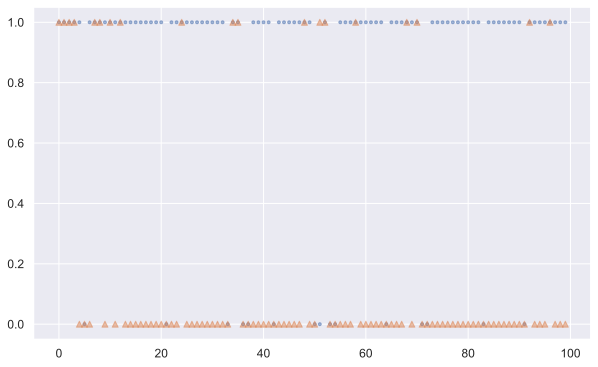

In [243]:
plt.plot(action_seq[:, 0], '.', alpha=.5)
plt.plot(action_seq[:, 1], '^', alpha=.5);

In [231]:
# # Obtain combined action matrix
# comb_act = utils.vis_action_matrix(action_seq)

# sns.heatmap(
#     comb_act,
#     annot=False,
#     cbar=False,
#     cmap=['w', 'darkgreen'],
#     vmin=0,
#     vmax=1,
#     yticklabels=['(D, D)', '(D, C)', '(C, D)', '(C, C)'],
#     xticklabels=[],
#     linewidths=.1,
#     linecolor='k',
# )

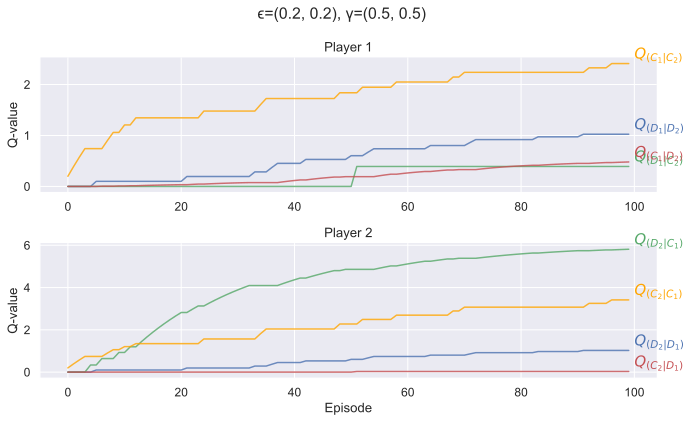

In [232]:
sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 6)})

fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})
fig.suptitle(
    f'ϵ=({config["params"]["eps"][0]}, {config["params"]["eps"][1]}), γ=({config["params"]["gamma"][0]}, {config["params"]["gamma"][1]})')

# Agent one
axs[0].set_title('Player 1')
agent_one_labels = ['$Q_{(D_1 | D_2)}$', '$Q_{(D_1 | C_2)}$', '$Q_{(C_1 | D_2)}$', '$Q_{(C_1 | C_2)}$',]
agent_one_colors = ['b', 'g', 'r', 'orange']
idx = 0
for action_i in range(config['num_actions']):
    for cond_act_i in range(config['num_actions']):
        axs[0].plot(
            q_traj_one[:, action_i, cond_act_i],
            color=agent_one_colors[idx], alpha=.8
        )
        axs[0].text(
            q_traj_one.shape[0],
            q_traj_one[-1, action_i, cond_act_i],
            agent_one_labels[idx],
            color=agent_one_colors[idx],
            fontsize=15,
            weight='bold',
            va='bottom',
        )
        idx += 1
    
axs[1].set_title('Player 2')
agent_one_labels = ['$Q_{(D_2 | D_1)}$', '$Q_{(D_2 | C_1)}$', '$Q_{(C_2 | D_1)}$', '$Q_{(C_2 | C_1)}$',]
agent_one_colors = ['b', 'g', 'r', 'orange']
idx = 0
for action_i in range(config['num_actions']):
    for cond_act_i in range(config['num_actions']):
        axs[1].plot(
            q_traj_two[:, action_i, cond_act_i],
            color=agent_one_colors[idx], alpha=.8
        )
        axs[1].text(
            q_traj_two.shape[0],
            q_traj_two[-1, action_i, cond_act_i],
            agent_one_labels[idx],
            color=agent_one_colors[idx],
            fontsize=15,
            weight='bold',
            va='bottom',
        )
        idx += 1

axs[0].set_ylabel('Q-value')
axs[1].set_ylabel('Q-value')
axs[1].set_xlabel('Episode')
sns.despine()
plt.tight_layout()

In [211]:
q_table_one

array([[0.45243813, 0.        ],
       [0.        , 0.        ]])

In [240]:
def run_extended_ipd_exp(config: Dict) -> Tuple[np.array, np.array, np.array, np.array]:
    '''
    Allow one agent to see the action of the other.
    '''

    game_env = PrisonersDilemmaEnv(
        config['payoffs']['R'], 
        config['payoffs']['T'], 
        config['payoffs']['S'], 
        config['payoffs']['P'],
    )

    # Initialize Q-tables (own act x other play act)
    q_table_one = np.zeros((game_env.action_space.n))
    q_table_two = np.zeros((game_env.action_space.n, game_env.action_space.n))

    q_traj_one = np.zeros((config['num_episodes'], game_env.action_space.n))
    q_traj_two = np.zeros((config['num_episodes'], game_env.action_space.n, game_env.action_space.n))
    rewards_seq = np.zeros((config['num_episodes'], config['num_agents']))
    action_seq = np.zeros((config['num_episodes'], config['num_agents']), dtype=int)

    # Condition the action of one agent on the action of the other
    for episode_i in range(config['num_episodes']):

        # # # # Select action player one # # # #
        if np.random.random() < config['params']['eps'][0]:
            act_play_one = np.array([game_env.action_space.sample()])
        else: # Exploit
            act_play_one = np.random.choice(
                 a=np.argwhere((q_table_one == q_table_one.max())).flatten(),
                size=(1,)
            )
        # # # # Select action player two | Condition on the action of player one # # # #
        if np.random.random() < config['params']['eps'][1]:
            act_play_two = np.array([game_env.action_space.sample()])
        else:  # Exploit
            act_play_two = np.random.choice(
                a=np.argwhere((q_table_two[:, act_play_one] == q_table_two[:, act_play_one].max())).flatten(),
                size=(1,)
            )

        # # # # Take a step # # # #
        actions = np.concatenate([act_play_one, act_play_two])
        _, rewards, _, _, _ = game_env.step(action=actions)

        # # # # Update Q-values # # # #
        q_table_one[act_play_one] = q_table_one[act_play_one] + \
            config['params']['alpha'][0] * (rewards[0] + config['params']['gamma'][0] * np.max(q_table_one) - q_table_one[act_play_one])

        q_table_two[act_play_two, act_play_one] = q_table_two[act_play_two, act_play_one] + \
            config['params']['alpha'][1] * (rewards[1] + config['params']['gamma'][1] * np.max(q_table_two[:, act_play_one]) - q_table_two[act_play_two, act_play_one])

        # Store trajectory
        rewards_seq[episode_i, :] = rewards
        action_seq[episode_i, :] = actions
        # episode x actions x players
        q_traj_one[episode_i, :] = q_table_one
        q_traj_two[episode_i, :, :] = q_table_two

    return (
        q_traj_one,
        q_traj_two,
        rewards_seq,
        action_seq,
    )